In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "mens-march-mania-2022"                      
[2] "us-cities"                                  
[3] "usa-2019-congressional-district-shape-files"
[4] "usa-cbsa-shapefiles"                        
[5] "usa-state-shapeflies"                       
[6] "usa-zip-shapefiles-2019"                    
[7] "zoo-animal-life-expectancies"

# Welcome to a Fun little Mapping Playground

In [2]:
library(sf)

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1



In [3]:
seeds <- read.csv('/kaggle/input/mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneySeeds.csv')
ranks <- read.csv('/kaggle/input/mens-march-mania-2022/MDataFiles_Stage1/MMasseyOrdinals.csv')
cities <- read.csv('/kaggle/input/mens-march-mania-2022/MDataFiles_Stage1/Cities.csv')
teams <- read.csv('/kaggle/input/mens-march-mania-2022/MDataFiles_Stage1/MTeams.csv')
seasoning <- read.csv('/kaggle/input/mens-march-mania-2022/MDataFiles_Stage1/MSeasons.csv')

city_zip <- read.csv('../input/us-cities/cities.csv')

In [4]:
game_cities <- read.csv('/kaggle/input/mens-march-mania-2022/MDataFiles_Stage1/MGameCities.csv')
head(game_cities)


,Season,DayNum,WTeamID,LTeamID,CRType,CityID
,<int>,<int>,<int>,<int>,<chr>,<int>
1,2010,7,1143,1293,Regular,4027
2,2010,7,1314,1198,Regular,4061
3,2010,7,1326,1108,Regular,4080
4,2010,7,1393,1107,Regular,4340
5,2010,9,1143,1178,Regular,4027
6,2010,9,1314,1300,Regular,4061


In [5]:
head(cities)

,CityID,City,State
,<int>,<chr>,<chr>
1,4001,Abilene,TX
2,4002,Akron,OH
3,4003,Albany,NY
4,4004,Albuquerque,NM
5,4005,Allentown,PA
6,4006,Ames,IA


In [6]:
str(teams)

'data.frame':	372 obs. of  4 variables:
 $ TeamID       : int  1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 ...
 $ TeamName     : chr  "Abilene Chr" "Air Force" "Akron" "Alabama" ...
 $ FirstD1Season: int  2014 1985 1985 1985 2000 1985 2000 1985 1985 1985 ...
 $ LastD1Season : int  2022 2022 2022 2022 2022 2022 2022 2022 1991 2022 ...


# Which team owns each State by most wins?

In [7]:
all_games <- merge(game_cities, cities, by = 'CityID')
all_games$city_state <- paste(all_games$City, all_games$State, sep="-")

all_games <- merge(all_games, teams %>% select(TeamID, TeamName), by.x = 'WTeamID',by.y = 'TeamID')

names(all_games) <- gsub("TeamName","Winning_Team", names(all_games))

wins_by_state <- all_games %>% 
                    group_by(State, Winning_Team) %>% 
                        count() %>%
                            group_by(State)%>% 
                                slice_max(n=1, order_by = n, with_ties = FALSE)

tourney_wins_by_state <- all_games %>%
                            subset(CRType == 'NCAA') %>%
                                group_by(State, Winning_Team) %>% 
                                    count() %>%
                                        group_by(State)%>% 
                                            slice_max(n=1, order_by = n, with_ties = FALSE)

That's great! But also the table is boring! Let's add a basic map.

In [8]:
district_shapes <- st_read('../input/usa-2019-congressional-district-shape-files')
state_shapes <- st_read('../input/../input/usa-state-shapeflies')
zip_shapes <- st_read('../input/usa-zip-shapefiles-2019')

head(state_shapes)

Reading layer `cb_2018_us_cd116_500k' from data source 
  `/kaggle/input/usa-2019-congressional-district-shape-files' 
  using driver `ESRI Shapefile'
Simple feature collection with 441 features and 8 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -179.1489 ymin: -14.5487 xmax: 179.7785 ymax: 71.36516
Geodetic CRS:  NAD83
Reading layer `cb_2018_us_state_500k' from data source 
  `/kaggle/input/usa-state-shapeflies' using driver `ESRI Shapefile'
Simple feature collection with 56 features and 9 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -179.1489 ymin: -14.5487 xmax: 179.7785 ymax: 71.36516
Geodetic CRS:  NAD83
Reading layer `tl_2019_us_zcta510' from data source 
  `/kaggle/input/usa-zip-shapefiles-2019' using driver `ESRI Shapefile'
Simple feature collection with 33144 features and 9 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -176.6847 ymin: -14.37378 xmax: 145.8305 ymax: 71.34132
Geodetic CRS:  NAD

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,MULTIPOLYGON (((-88.50297 3...
2,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,MULTIPOLYGON (((-75.72681 3...
3,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,MULTIPOLYGON (((-103.0026 3...
4,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,MULTIPOLYGON (((-75.74241 3...
5,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,MULTIPOLYGON (((-82.6432 38...
6,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,MULTIPOLYGON (((-88.8677 29...


Awesome, we brought in state shapefiles! Let's have a look!

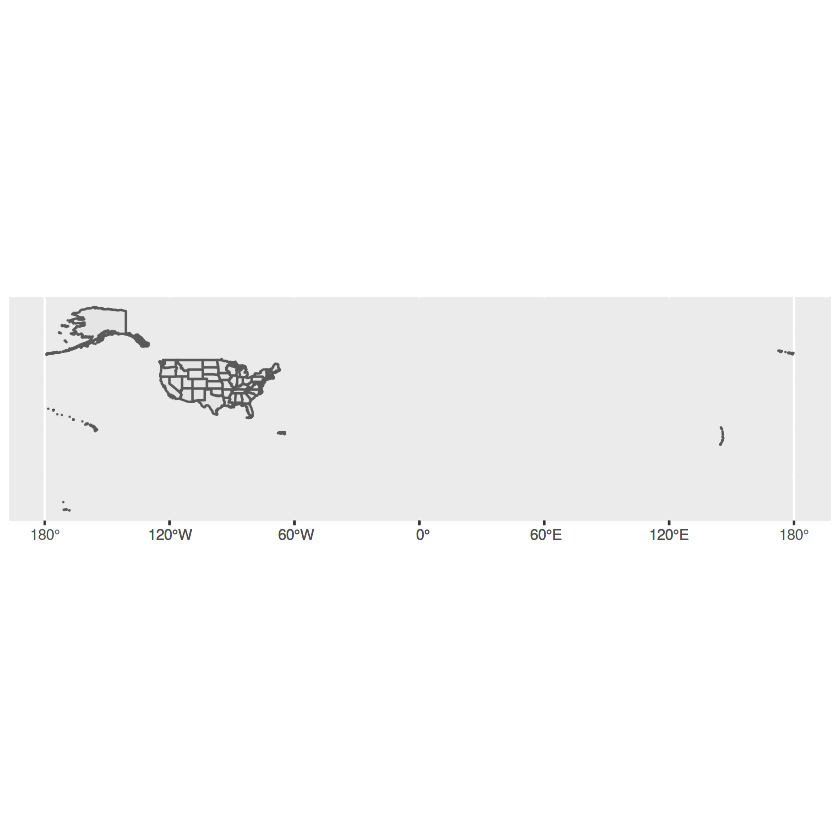

In [9]:
ggplot(state_shapes) + geom_sf()

Awesome!? So comprehensive we even have Guam & American Samoa. 

<b>Cropping the continental US</b>

Let's focus on just the continental US for now. This code creates a filter box, use ST_CROP to reduce our state and district files to just the region we need. 


Spherical geometry (s2) switched off


although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


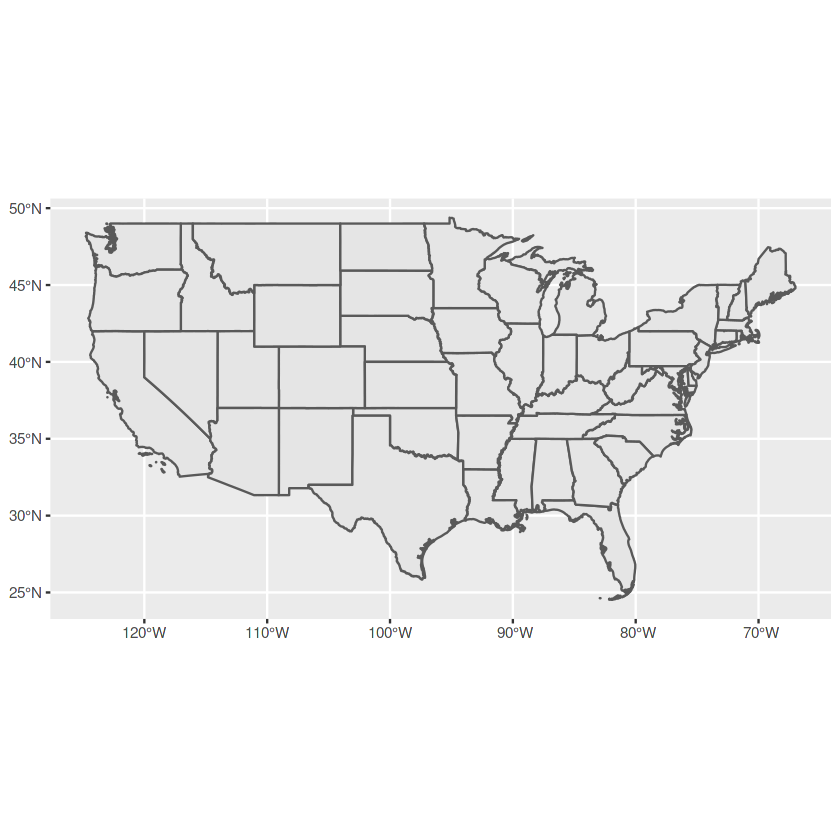

In [10]:
filter_box <- st_bbox(c(xmin = -126, xmax = -67, ymax = 20, ymin =100), crs = st_crs("NAD83"))
sf_use_s2(FALSE)
district_shapes <- st_crop(district_shapes, filter_box)
state_shapes <- st_crop(state_shapes, filter_box)

ggplot(state_shapes) + geom_sf()

That's better for our purposes! 

Now we can add merge the shapefiles with our wins so we can map. 

In [11]:
wins_by_state <- merge(wins_by_state, state_shapes, by.x = "State", by.y = "STUSPS", all = F)
head(wins_by_state)

tourney_wins_by_state <- merge(tourney_wins_by_state, state_shapes, by.x = "State", by.y = "STUSPS", all.x = F, all.y = T)
head(tourney_wins_by_state)

,State,Winning_Team,n,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<GEOMETRY [°]>
1,AL,Alabama,170,01,01779775,0400000US01,01,Alabama,00,131174048583,4593327154,MULTIPOLYGON (((-88.05338 3...
2,AR,Arkansas,202,05,00068085,0400000US05,05,Arkansas,00,134768872727,2962859592,POLYGON ((-94.61783 36.4994...
3,AZ,Arizona,197,04,01779777,0400000US04,04,Arizona,00,294198551143,1027337603,POLYGON ((-114.8163 32.5080...
4,CA,St Mary's CA,254,06,01779778,0400000US06,06,California,00,403503931312,20463871877,MULTIPOLYGON (((-118.6044 3...
5,CO,Colorado,180,08,01779779,0400000US08,08,Colorado,00,268422891711,1181621593,POLYGON ((-109.0603 38.5993...
6,CT,Connecticut,162,09,01779780,0400000US09,09,Connecticut,00,12542497068,1815617571,MULTIPOLYGON (((-72.76143 4...


,State,Winning_Team,n,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<GEOMETRY [°]>
1,AL,NA,NA,01,01779775,0400000US01,01,Alabama,00,131174048583,4593327154,MULTIPOLYGON (((-88.05338 3...
2,AR,NA,NA,05,00068085,0400000US05,05,Arkansas,00,134768872727,2962859592,POLYGON ((-94.61783 36.4994...
3,AZ,Louisville,2,04,01779777,0400000US04,04,Arizona,00,294198551143,1027337603,POLYGON ((-114.8163 32.5080...
4,CA,Oregon,7,06,01779778,0400000US06,06,California,00,403503931312,20463871877,MULTIPOLYGON (((-118.6044 3...
5,CO,Gonzaga,3,08,01779779,0400000US08,08,Colorado,00,268422891711,1181621593,POLYGON ((-109.0603 38.5993...
6,CT,Florida St,2,09,01779780,0400000US09,09,Connecticut,00,12542497068,1815617571,MULTIPOLYGON (((-72.76143 4...


Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”
Warning message in st_point_on_surface.sf

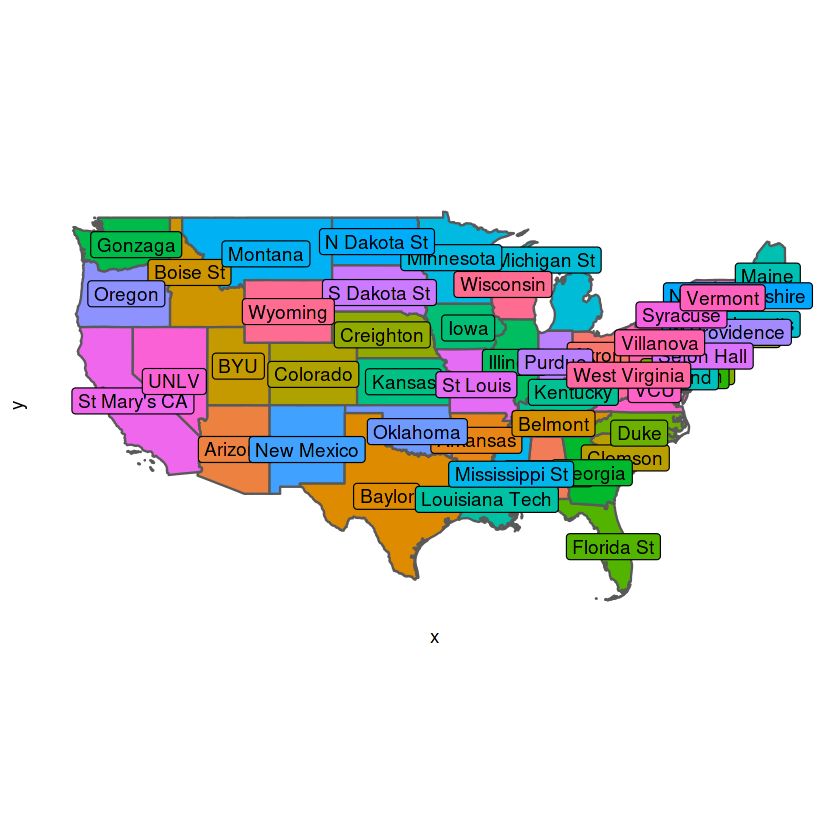

In [12]:
st_geometry(wins_by_state) <- wins_by_state$geometry

ggplot(wins_by_state, aes(fill = Winning_Team)) + geom_sf() + geom_sf_label(aes(label = Winning_Team)) +
     theme(panel.background = element_blank(), axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), legend.position = 'none')

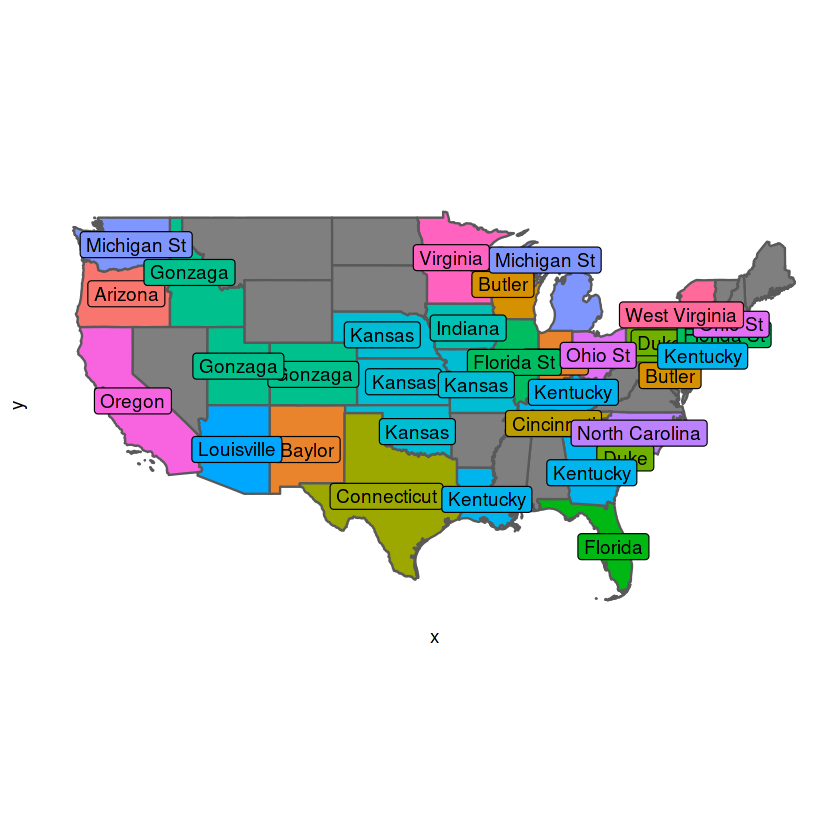

In [13]:
st_geometry(tourney_wins_by_state) <- tourney_wins_by_state$geometry
options(warn = -1)
ggplot(tourney_wins_by_state, aes(fill = Winning_Team, label=as.character(Winning_Team))) + geom_sf() + geom_sf_label(aes(label = Winning_Team)) +
     theme(panel.background = element_blank(), axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), legend.position = 'none')

# [No games in Nevada? I didn't realize that, but it's not going last ](https://www.cbssports.com/college-basketball/news/las-vegas-set-to-host-ncaa-tournament-regional-as-march-madness-locations-announced-through-2026/)

# Reach out to me about any [data science jobs at Stryker](https://careers.stryker.com/job-search-results/?keyword=data%20scientist)!

We have jobs to suit almost any level of data science / analytics ability!